In [25]:
# import jaxlib
# from jax_unirep import get_reps
import os
from time import time

from collections import defaultdict
# from UniRep.unirep_utils import get_UniReps

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, roc_curve, auc, plot_confusion_matrix
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import label_binarize

from scipy import interp
from itertools import cycle

# from Bio.SeqUtils import molecular_weight
# from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP

import warnings
warnings.filterwarnings('ignore')

In [2]:
def train_opt_model(model_class, parameters, X_train, y_train, scoring, refit_sc):
    """Trains a classifier with 5 fold cross validation.
    
    Trains a classifier on training data performing 5 fold cross validation and testing multiple parameters.
    
    
    Inputs:
        model_class: the sklearn class of the classifier
        parameters: a parameter grid dictionary with the parameters and values to test
        X_train: features of the training set
        y_train: classes of the training set
        scoring: a sklearn scoring object with the score metrics to use
        refit_sc: the score metric to select the parameters that yield the best classifier
        
    Outputs:
        clf: the trained classifier
    """
    clf = GridSearchCV(model_class, parameters, cv=5, scoring=scoring, refit=refit_sc, verbose=3, n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf

In [3]:
def plot_param_search_1d(trained_model, parameters, refit_sc):

    # convert dictionary to lists for ease of use
    param_values = list(parameters.values())
    param_names = list(parameters.keys())
        
    # results
    cv_results = pd.DataFrame(trained_model.cv_results_)
    
    # print results of best classifier
    if 'rank_test_AUC' in cv_results:
        print('For the model optimized by AUC:')
        print('\t the parameter is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'params'].to_string(index=False)))
        print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_AUC'].to_string(index=False)))
        print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_Accuracy'].to_string(index=False)))

    print('For the model optimized by Accuracy:')
    print('\t the parameter is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'params'].to_string(index=False)))
    if 'rank_test_AUC' in cv_results:
        print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_AUC'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_Accuracy'].to_string(index=False)))
    
    
    print("Optimizing by",refit_sc,"so best parameters are: {}".format(trained_model.best_params_))
    
    # plot results
    if 'rank_test_AUC' in cv_results:
        acc_eval_scores = np.transpose(np.array(cv_results.mean_test_AUC))
    else:
        acc_eval_scores = np.transpose(np.array(cv_results.mean_test_Accuracy))
    
    # xaxis
    scores_dict = {param_names[0]: parameters[param_names[0]]}   
    
    param_df = pd.DataFrame(scores_dict)
    
    sns.lineplot(parameters[param_names[0]], acc_eval_scores)
    
    plt.ylabel(refit_sc)
    plt.xlabel(param_names[0])
    plt.axvline(trained_model.best_params_[param_names[0]], 0,1, linestyle="dashed", color="grey")
    plt.tight_layout()
    # plt.savefig("model.png", dpi=600)
    plt.show()
    return None

In [4]:
def plot_param_search(trained_model, parameters, refit_sc):
    # assert que parameters son exactament 2, sino no es pot fer

    # results
    cv_results = pd.DataFrame(trained_model.cv_results_)

    # print results of best classifier
    if 'rank_test_AUC' in cv_results:
        print('For the model optimized by AUC:')
        print('\t the parameters are: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'params'].to_string(index=False)))
        print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_AUC'].to_string(index=False)))
        print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_Accuracy'].to_string(index=False)))

    print('For the model optimized by Accuracy:')
    print('\t the parameters are: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'params'].to_string(index=False)))
    if 'rank_test_AUC' in cv_results:
        print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_AUC'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_Accuracy'].to_string(index=False)))
    
    
    print("Optimizing by",refit_sc,"so best parameters are: {}".format(trained_model.best_params_))
        
    # plot results
    if 'rank_test_AUC' in cv_results:
        rlt = pd.concat([pd.DataFrame(trained_model.cv_results_["params"]),
                         pd.DataFrame(trained_model.cv_results_["mean_test_AUC"], columns=["AUC"])],axis=1)
    else:
        rlt = pd.concat([pd.DataFrame(trained_model.cv_results_["params"]),
                         pd.DataFrame(trained_model.cv_results_["mean_test_Accuracy"], columns=["Accuracy"])],axis=1)
    
    # get parameter with less values to go to x axis    
    param_values = list(parameters.values())
    param_names = list(parameters.keys())
    # select the parameter with more values as x axis (reverse if necessary)
    if len(param_values[0]) < len(param_values[1]):
        param_values.reverse()
        param_names.reverse()
    
    sns.lineplot(x=param_names[0], y=refit_sc, hue=param_names[1], data=rlt)
    plt.axvline(trained_model.best_params_[param_names[0]], 0,1, linestyle="dashed", color="grey")
    plt.tight_layout()
    # plt.savefig("model.png", dpi=600)
    plt.show()
    return None

In [5]:
def plot_roc_curve(trained_classifier, model_name, X_test, y_test, roc_col):
    # adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # Binarize the output
    y_labs = label_binarize(y_test, classes=['cytoplasm', 'membrane','secreted'])
    n_classes = y_labs.shape[1]
    
    if str(trained_classifier)[:3] == 'SVC':
        pred_probs = trained_classifier.predict_proba(X_test)
        preds = trained_classifier.predict(X_test)
    else:
        pred_probs = trained_classifier.best_estimator_.predict_proba(X_test)
        preds = trained_classifier.best_estimator_.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, preds) 
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_labs[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
             label=str(model_name)+', AUC: {:.3f}'.format(roc_auc["macro"]),
             color=roc_col, linestyle='-', linewidth=1)
    
    return test_accuracy, roc_auc["macro"]

In [6]:
# Importing the true data sets with unirep features
human_unirep_all = pd.read_pickle('UniRep_datasets/combined_human_UniRep_dataset_noSP.pkl')

In [7]:
# Running the model comparison on human data set WITH signal peptides
X = np.stack(human_unirep_all["UniRep"].to_numpy())
y = np.array(human_unirep_all['location'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# the dataset is unbalanced
pd.Series(y).value_counts()

cytoplasm    5038
membrane     3830
secreted      895
dtype: int64

In [9]:
model_names = [
    'kNN',
    'LogReg',
    'RF',
    'MLP',
    'AdaBoost',
    'RBF SVM',
    'lin SVM'
]

models = [
    KNeighborsClassifier(),
    LogisticRegression(solver='liblinear'),
    RandomForestClassifier(),
    MLPClassifier(max_iter=200),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)),
    SVC(kernel='rbf'),
    SVC(kernel='linear')
]

params = [
    # for kNN
    {'n_neighbors':[int(np.sqrt(len(y_train))/16),
                       int(np.sqrt(len(y_train))/8),
                       int(np.sqrt(len(y_train))/4),
                       int(np.sqrt(len(y_train))/2),
                       int(np.sqrt(len(y_train))),
                       int(np.sqrt(len(y_train))*2),
                       int(np.sqrt(len(y_train))*4)],
    'weights': ['uniform', 'distance']},
    # for LogisticRegression
    {'C'             : [1e-3,1e-1,1,10],
    'penalty'       : ["l1","l2"]},
    # for RandomForest
    {'n_estimators':[1,5,10,20],
     'max_depth':[1,30,150]},
    # for MLP works fine but slow
    {'hidden_layer_sizes':[50,100],
     'alpha':[1e-4,1e-2,1e-1]},
    # for AdaBoost
    {'n_estimators':[10,50,100],
     'learning_rate':[0.1,1]},
    # for RBF SVM
    {'C':[1e-4, 1e-2, 1, 10, 50],
     'gamma':['scale','auto']},
    # for linear SVM
    {'C':[1e-4, 1e-2, 1, 10, 50]}
]

In [10]:
# ovo: One versus One and averaging macro, not affected by class imbalance (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
scoring = {'Accuracy': make_scorer(accuracy_score),
           'AUC':'roc_auc_ovo'}
refit_sc = 'AUC'

Started training model kNN
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Finished training model in 57.0 seconds

For the model optimized by AUC:
	 the parameters are: {'n_neighbors': 11, 'weights': 'distance'}
	 the AUC is: 0.942746
	 the accuracy is: 0.904994
For the model optimized by Accuracy:
	 the parameters are: {'n_neighbors': 5, 'weights': 'distance'}
	 the AUC is: 0.938457
	 the accuracy is: 0.909603
Optimizing by AUC so best parameters are: {'n_neighbors': 11, 'weights': 'distance'}


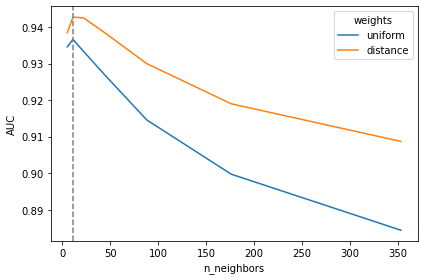

---------------------------

Started training model LogReg
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Finished training model in 230.14 seconds

For the model optimized by AUC:
	 the parameters are: {'C': 10, 'penalty': 'l2'}
	 the AUC is: 0.959615
	 the accuracy is: 0.922535
For the model optimized by Accuracy:
	 the parameters are: {'C': 10, 'penalty': 'l2'}
	 the AUC is: 0.959615
	 the accuracy is: 0.922535
Optimizing by AUC so best parameters are: {'C': 10, 'penalty': 'l2'}


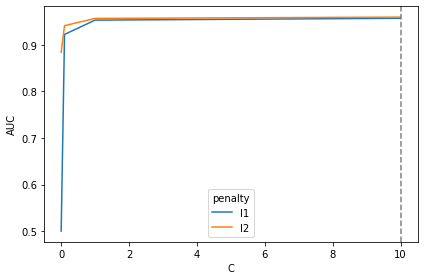

---------------------------

Started training model RF
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Finished training model in 40.93 seconds

For the model optimized by AUC:
	 the parameters are: {'max_depth': 30, 'n_estimators': 20}
	 the AUC is: 0.956115
	 the accuracy is: 0.915365
For the model optimized by Accuracy:
	 the parameters are: {'max_depth': 150, 'n_estimators': 20}
	 the AUC is: 0.954006
	 the accuracy is: 0.916389
Optimizing by AUC so best parameters are: {'max_depth': 30, 'n_estimators': 20}


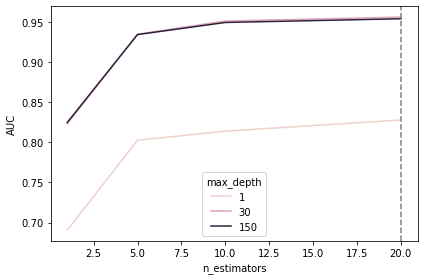

---------------------------

Started training model MLP
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Finished training model in 489.86 seconds

For the model optimized by AUC:
	 the parameters are: {'alpha': 0.1, 'hidden_layer_sizes': 100}
	 the AUC is: 0.963862
	 the accuracy is: 0.922279
For the model optimized by Accuracy:
	 the parameters are: {'alpha': 0.01, 'hidden_layer_sizes': 100}
	 the AUC is: 0.963228
	 the accuracy is: 0.926633
Optimizing by AUC so best parameters are: {'alpha': 0.1, 'hidden_layer_sizes': 100}


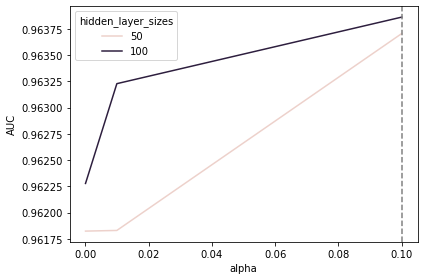

---------------------------

Started training model AdaBoost
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Finished training model in 828.26 seconds

For the model optimized by AUC:
	 the parameters are: {'learning_rate': 0.1, 'n_estimators': 100}
	 the AUC is: 0.922875
	 the accuracy is: 0.886428
For the model optimized by Accuracy:
	 the parameters are: {'learning_rate': 0.1, 'n_estimators': 100}
	 the AUC is: 0.922875
	 the accuracy is: 0.886428
Optimizing by AUC so best parameters are: {'learning_rate': 0.1, 'n_estimators': 100}


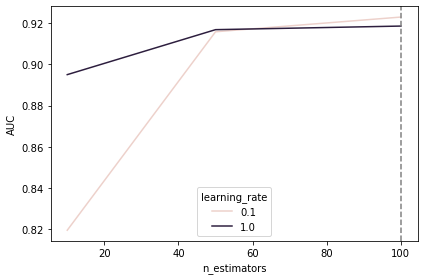

---------------------------

Started training model RBF SVM
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Finished training model in 528.69 seconds

For the model optimized by Accuracy:
	 the parameters are: {'C': 10, 'gamma': 'scale'}
	 the accuracy is: 0.933931
Optimizing by Accuracy so best parameters are: {'C': 10, 'gamma': 'scale'}


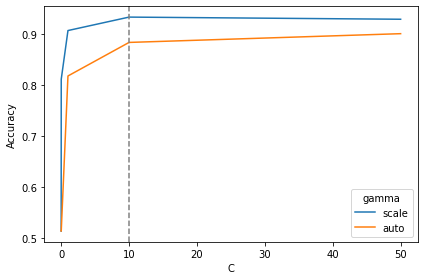

---------------------------

Started training model lin SVM
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finished training model in 249.67 seconds

For the model optimized by Accuracy:
	 the parameter is: {'C': 1}
	 the accuracy is: 0.925992
Optimizing by Accuracy so best parameters are: {'C': 1}


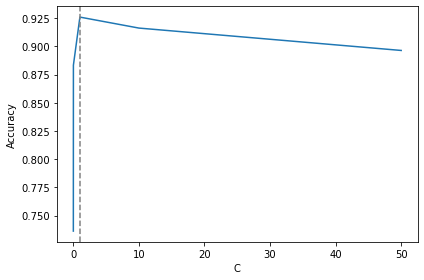

---------------------------



In [11]:
trained_models = []

for model, parameters, mod_name in zip(models,params, model_names):
    print("Started training model", mod_name)
    time_0 = time()
    
    if str(model)[:3] == 'SVC':
        trn_clf = train_opt_model(model, parameters, X_train, y_train,
                                  {'Accuracy':make_scorer(accuracy_score)}, 'Accuracy')
        print("Finished training model in", round(time()-time_0,2),"seconds\n")
        
        if len(parameters) == 2:
            plot_param_search(trn_clf, parameters, 'Accuracy')
        else:
            plot_param_search_1d(trn_clf, parameters, 'Accuracy')
        
        # retrain calculating probabilities
        best_parm = trn_clf.best_params_
        if len(best_parm) == 2: #for rbf kerlen
            trn_clf = SVC(kernel='rbf', C=best_parm['C'], gamma=best_parm['gamma'], probability=True)
        else:
            trn_clf = SVC(kernel='linear', C=best_parm['C'], probability=True)
        
        trn_clf.fit(X_train, y_train)
        
    else:
        trn_clf = train_opt_model(model, parameters, X_train, y_train, scoring, refit_sc)
        print("Finished training model in", round(time()-time_0,2),"seconds\n")

        if len(parameters) == 2:
            plot_param_search(trn_clf, parameters, refit_sc)
        else:
            plot_param_search_1d(trn_clf, parameters, refit_sc)
    
    trained_models.append(trn_clf)
    print("---------------------------\n")

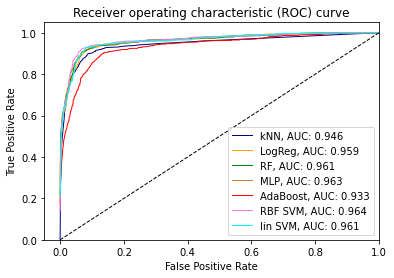

In [12]:
compare_auc = []
compare_accuracy = []
roc_colors = ['navy','orange','green','peru','red','violet','cyan']

for trn_model, mod_name, roc_col in zip(trained_models, model_names, roc_colors):
    test_accuracy, test_auc_val = plot_roc_curve(trn_model, mod_name, X_test, y_test, roc_col)
    compare_auc.append(test_auc_val)
    compare_accuracy.append(test_accuracy)
    
    
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

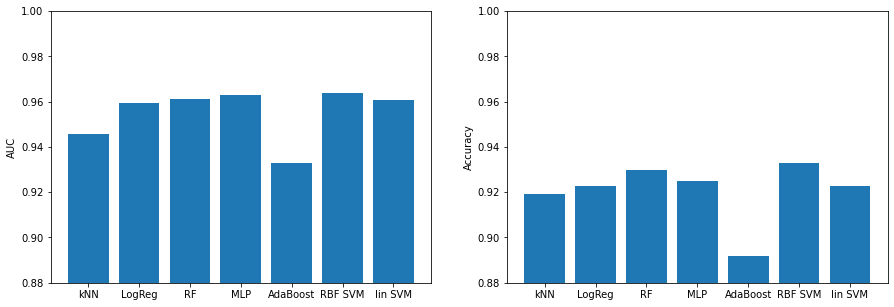

In [17]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].bar(model_names, compare_auc)
axs[1].bar(model_names, compare_accuracy)

axs[0].set_ylabel('AUC')
axs[1].set_ylabel('Accuracy')

axs[0].set_ylim(0.88,1.0)
axs[1].set_ylim(0.88,1.0)

plt.show()

### Select best model

In [18]:
best_model_name = 'LogReg'

In [19]:
# just to confirm, the selected model is:
trained_models[model_names.index(best_model_name)].estimator

LogisticRegression(solver='liblinear')

In [20]:
# get the best model and best parameters
print('The best parameters are {}'.format(trained_models[model_names.index(best_model_name)].best_params_))

The best parameters are {'C': 10, 'penalty': 'l2'}


In [21]:
# should now retrain with all data, but here we take the best estimator trained on training dataset
best_mod = trained_models[model_names.index(best_model_name)].best_estimator_

In [22]:
# get a confusion matrix of the test dataset for that model
preds = best_mod.predict(X_test)

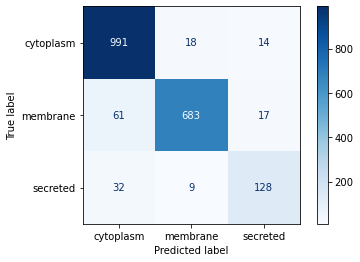

In [23]:
plot_confusion_matrix(best_mod, X_test, y_test,
                      display_labels=['cytoplasm', 'membrane','secreted'],
                      cmap=plt.cm.Blues)
plt.show()

In [29]:
pickle.dump(best_mod, open("trained_models/human_noSP_opt_logreg.pkl", 'wb'))

In [30]:
loaded_model = pickle.load(open("trained_models/human_noSP_opt_logreg.pkl", 'rb'))

In [31]:
# if zero: all predictions match, the model was loaded correctly
len(preds) - (loaded_model.predict(X_test) == preds).sum()

0